In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np

In [4]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the parameters (move to GPU)
num_samples = 50000

# Define the function for the analytical solution
def x_analytical(t_train):
    x0 = 10  # Initial position
    v = 2  # Constant velocity
    return torch.clamp(x0 + v * t_train, min=0).to(device)  # Rectified linear movement (URM)

# Define your dataset
t = torch.rand(100, 1).to(device)  # Move to GPU
x_analytic = x_analytical(t)

# Split the dataset into training and testing subsets
t_train, t_test, x_train, x_test = train_test_split(t.cpu(), x_analytic.cpu(), test_size=0.2, random_state=42)  # Move to CPU for splitting

# Move training and testing data to GPU
t_train, x_train = t_train.to(device), x_train.to(device)
t_test, x_test = t_test.to(device), x_test.to(device)

# Create TensorDatasets for training and testing
train_dataset = TensorDataset(t_train, x_train)
test_dataset = TensorDataset(t_test, x_test)

# Define batch size for training and testing data loaders
batch_size = 64

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print out some data points for illustration
print("Train dataset size:", len(train_dataset))
print("Test dataset size:", len(test_dataset))


Train dataset size: 80
Test dataset size: 20


In [5]:
# Convert the training and testing data to numpy arrays
t_train_np, x_train_np = t_train.cpu().numpy(), x_train.cpu().numpy()
t_test_np, x_test_np = t_test.cpu().numpy(), x_test.cpu().numpy()

# Define the XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Train the XGBoost model
xgb_model.fit(t_train_np, x_train_np)

# Make predictions on the testing data
xgb_preds = xgb_model.predict(t_test_np)

# Evaluate the model
mse = mean_squared_error(x_test_np, xgb_preds)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0008498992


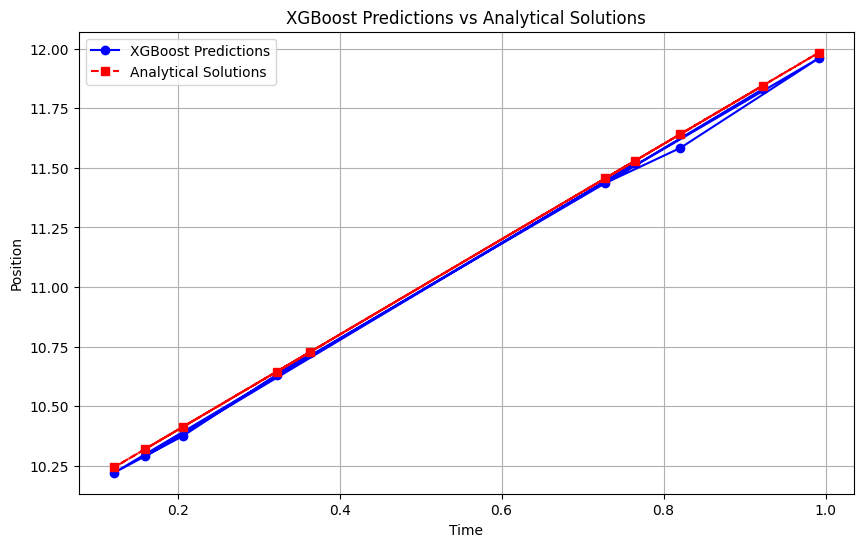

In [9]:
# Define a set of different times
times_np = np.random.rand(10, 1)

# Make predictions using the XGBoost model
xgb_preds = xgb_model.predict(times_np)

# Convert times to torch tensors for analytical solution calculation
times_tensor = torch.tensor(times_np, dtype=torch.float32, device=device)

# Calculate analytical solutions for each time
analytical_solutions = x_analytical(times_tensor).cpu().numpy()

# Plot model predictions and analytical solutions against time
plt.figure(figsize=(10, 6))
plt.plot(times_np, xgb_preds, marker='o', linestyle='-', color='blue', label='XGBoost Predictions')
plt.plot(times_np, analytical_solutions, marker='s', linestyle='--', color='red', label='Analytical Solutions')
plt.title('XGBoost Predictions vs Analytical Solutions')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.grid(True)
plt.show()